In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import PIL.Image

root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils, plot_utils, grid_utils

In [3]:
from analyze_behav import process_behav
process_behav.preproc_training_sessions()

210406 S01
Subject 01 is missing run 2 for part 4
Subject 01 is missing run 2 for part 5
Subject 01 is missing run 2 for part 6
(array([1, 2, 3], dtype=object), array([144, 144, 144]))
(array([1, 2], dtype=object), array([288, 144]))
writing to /usr/local/serenceslab/maggie/shapeDim/DataBehavior/S01/S01_trainingsess_preproc_all.csv
210625 S05
(array([1, 2, 3], dtype=object), array([192, 192, 192]))
(array([1, 2], dtype=object), array([288, 288]))
writing to /usr/local/serenceslab/maggie/shapeDim/DataBehavior/S02/S02_trainingsess_preproc_all.csv
210703 S06
(array([1, 2, 3], dtype=object), array([192, 192, 192]))
(array([1, 2], dtype=object), array([288, 288]))
writing to /usr/local/serenceslab/maggie/shapeDim/DataBehavior/S03/S03_trainingsess_preproc_all.csv
210709 S04
(array([1, 2, 3], dtype=object), array([192, 192, 192]))
(array([1, 2], dtype=object), array([288, 288]))
writing to /usr/local/serenceslab/maggie/shapeDim/DataBehavior/S04/S04_trainingsess_preproc_all.csv
210708 S05
(arr

In [6]:
sublist = [1,2,3,4,5,6,7]
subjects = sublist
n_subj = len(subjects)

all_grid_points = grid_utils.get_full_grid()
n_pts_all_grid = all_grid_points.shape[0]


task_names = ['Linear (1)','Linear (2)','Checker'];
n_tasks = len(task_names)
acc_by_task = np.zeros((n_subj, n_tasks));
acc_by_task_easy = np.zeros((n_subj, n_tasks));
acc_by_task_hard = np.zeros((n_subj, n_tasks));

n_runs_total = 12
acc_by_run = np.full(fill_value=np.nan, shape=(n_subj, n_runs_total));

n_runs_each_task = int(n_runs_total / n_tasks)
diff_by_task = np.full(fill_value=np.nan, shape=(n_subj, n_tasks, n_runs_each_task));

# count how many trials they respond with each category label
resp_values = ['1','2','none']
n_resp_each_point = np.zeros((n_subj, n_tasks, n_pts_all_grid, len(resp_values)))

for si, ss in enumerate(subjects):
    
    bdat = pd.read_csv(os.path.join(root, 'DataBehavior','S%02d'%ss, 'S%02d_trainingsess_preproc_all.csv'%ss), \
                       index_col = 0)
    print(ss, bdat.shape[0]/48)
    print(np.unique(bdat['run_difficulty']))
    
    resp = np.array(bdat['resp'])
    correct_resp = np.array(bdat['correct_resp'])
    
    for ti in range(n_tasks):
        
        inds = (bdat['task']==(ti+1)) & (bdat['timeout']==False)
        acc_by_task[si,ti] = np.mean(correct_resp[inds]==resp[inds])
        
        inds = (bdat['task']==(ti+1)) & (bdat['timeout']==False) & (bdat['is_main_grid']==1)
        acc_by_task_easy[si,ti] = np.mean(correct_resp[inds]==resp[inds])
    
        inds = (bdat['task']==(ti+1)) & (bdat['timeout']==False) & (bdat['is_main_grid']==0)
        acc_by_task_hard[si,ti] = np.mean(correct_resp[inds]==resp[inds])
    
        runs_this_task = np.unique(bdat['run_overall'][bdat['task']==(ti+1)])
        # print(ti, runs_this_task)
        for ri, rr in enumerate(runs_this_task):
            
            diff = np.array(bdat['run_difficulty'][bdat['run_overall']==rr])[0]
            
            diff_by_task[si,ti,ri] = diff
        
    runs_overall = np.unique(bdat['run_overall'])
    # print(runs_overall)
    for ri,rr in enumerate(runs_overall):
        
        inds = (bdat['run_overall']==rr) & (bdat['timeout']==False)
        a = np.mean(resp[inds]==correct_resp[inds])
        # if a<0.50:
        #     print(ss, rr, np.sum(inds), a)
        #     print(resp[inds], correct_resp[inds])
        acc_by_run[si,ri] = a

    # loop over all trials
    for tr in range(bdat.shape[0]):
        dat = bdat.iloc[tr]
        
        task_ind = dat['task'] - 1
        grid_point_ind = np.where((all_grid_points[:,0]==dat['ptx']) & (all_grid_points[:,1]==dat['pty']))[0]
        assert(len(grid_point_ind)==1)
        if not np.isnan(dat['resp_unmapped']):
            resp_ind = int(dat['resp_unmapped']) - 1
        else:
            resp_ind = 2;
            
        n_resp_each_point[si,task_ind,grid_point_ind[0], resp_ind] +=1

1 9.0
[ 9 10 11]
2 12.0
[11]
3 12.0
[11]
4 12.0
[11]
5 12.0
[ 9 11]
6 12.0
[11]
7 12.0
[ 9 10 11]


In [28]:
np.unique(bdat['run_difficulty'])

array([ 9, 10, 11])

In [8]:
acc_by_run.shape

(7, 12)

/home/AD/mmhender/anaconda3/envs/shapedim/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


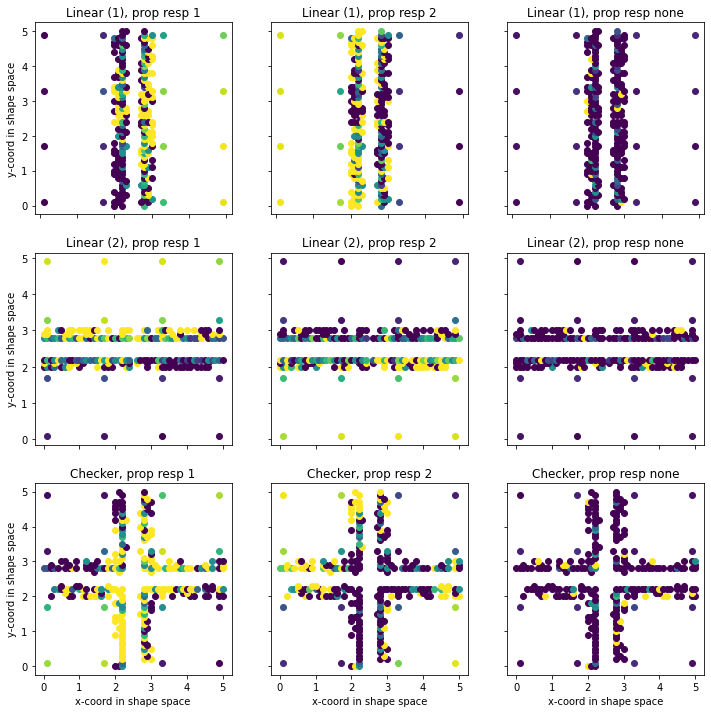

In [9]:
from matplotlib import cm

plt.figure(figsize=(12,12))
pi=0

# first summing over subjects
n_resp_summed = np.sum(n_resp_each_point, axis=0)

# now converting to a proportion of all trials
denom = np.tile( np.sum(n_resp_summed, axis=2, keepdims=True), [1,1,3])
prop_resp = n_resp_summed / denom
prop_resp[denom==0] = np.nan

# make a colormap
color_inds = np.linspace(0,1,100)
colors = cm.viridis(color_inds)

n_tasks = len(task_names)
for ti in range(n_tasks):
    
    for ri, resp_str in enumerate(resp_values):
        
        pr = prop_resp[ti,:,ri]
    
        pi+=1
        
        plt.subplot(3,3,pi)
        
        for pt in range(n_pts_all_grid):
            
            # plot the point if it was ever tested, skip if not
            if ~np.isnan(pr[pt]):
                
                # figure out what color to use, based on proportion value
                cind = np.argmin(np.abs(pr[pt]-color_inds))
                plt.plot(all_grid_points[pt,0], all_grid_points[pt,1], 'o', color=colors[cind])
    
        plt.title('%s, prop resp %s'%(task_names[ti], resp_str))
        
        if ti==2:
            plt.xlabel('x-coord in shape space')
            plt.xticks(np.arange(0,5.1,1))
        else:
            plt.xticks(np.arange(0,5.1,1),[])
        
        if ri==0:
            plt.ylabel('y-coord in shape space')
            plt.yticks(np.arange(0,5.1,1))
        else:
            plt.yticks(np.arange(0,5.1,1),[])
        
        

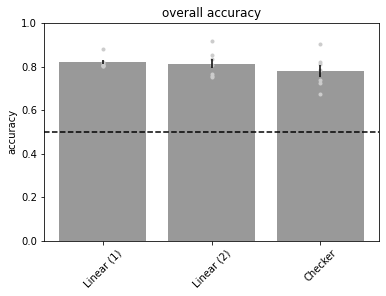

In [10]:
plt.figure(figsize=(6,4))

vals = np.concatenate([acc_by_task], axis=1) 
n_tasks = vals.shape[1]
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subj)
plt.bar(np.arange(n_tasks), meanvals, color=[0.6, 0.6, 0.6])
plt.errorbar(np.arange(n_tasks), meanvals, semvals, linestyle='none', color='k', zorder=10)
for si in range(n_subj):
    plt.plot(np.arange(n_tasks), vals[si,:], '.', color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(n_tasks), task_names , rotation=45)
plt.ylabel('accuracy')
plt.ylim([0, 1.0])
plt.axhline(0.5, color='k', linestyle='--')
plt.title('overall accuracy');

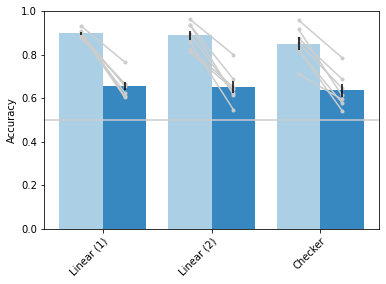

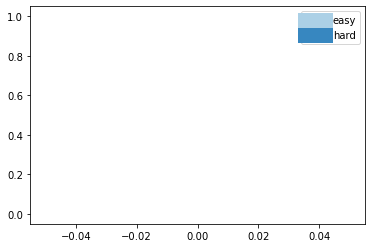

In [11]:
from code_utils import plot_utils
from matplotlib import cm

vals1 = np.concatenate([acc_by_task_easy[:,:,None], acc_by_task_hard[:,:,None]], axis=2)
# vals2 = np.concatenate([acc_repeat_task_easy[:,:,None], acc_repeat_task_hard[:,:,None]], axis=2)
# vals =np.concatenate([vals1, vals2], axis=1)
vals = vals1
n_tasks = vals.shape[1]

meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subj)
plot_utils.plot_multi_bars(mean_data=meanvals, err_data=semvals, point_data=vals, \
                           fig_size=(6,4), space = 0.1, \
                           add_ss_lines=True,
                          colors = cm.Blues(np.linspace(0,1,4))[1:3,:], \
                          legend_labels = ['easy','hard'], \
                          ylim = [0, 1], \
                          horizontal_line_pos = 0.5, \
                          xticklabels = task_names, \
                          ylabel='Accuracy');


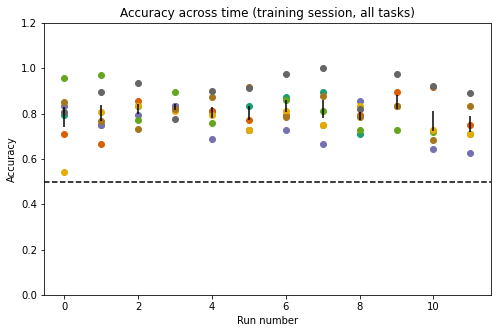

In [19]:
subcolors = cm.Dark2(np.linspace(0,1,n_subj))

plt.figure(figsize=(8,5))
for ri in range(n_runs_total):
    vals = acc_by_run[:,ri]
    
    for si in range(n_subj):
        plt.plot(ri, vals[si], 'o', color=subcolors[si,:])
    vals = vals[~np.isnan(vals)]
    m = np.mean(vals)
    s = np.std(vals)/np.sqrt(len(vals))
    plt.errorbar(ri, m, s, color='k', zorder=10)
    
plt.ylabel('Accuracy')
plt.axhline(0.5, color='k', linestyle='--')
plt.title('Accuracy across time (training session, all tasks)');
plt.xlabel('Run number');
plt.ylim([0.0, 1.2]);

# for se in np.arange(0, 37, 12):
#     plt.axvline(se-0.5, color=[0.9, 0.9, 0.9]);

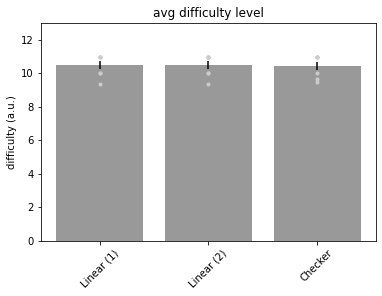

In [20]:
meandiff = np.nanmean(diff_by_task, axis=2)
vals = meandiff
n_tasks = meandiff.shape[1]

plt.figure(figsize=(6,4))

meanvals = np.nanmean(vals, axis=0)
semvals = np.nanstd(vals, axis=0)/np.sqrt(np.sum(~np.isnan(vals), axis=0))

plt.bar(np.arange(n_tasks), meanvals, color=[0.6, 0.6, 0.6])
plt.errorbar(np.arange(n_tasks), meanvals, semvals, linestyle='none', color='k', zorder=10)
for si in range(n_subj):
    plt.plot(np.arange(n_tasks), vals[si,:], '.', color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(n_tasks), task_names, rotation=45)
plt.ylabel('difficulty (a.u.)')
plt.ylim([0,13])
# plt.axhline(0.5, color='k', linestyle='--')
plt.title('avg difficulty level');

In [45]:
acc_by_task.shape

(7, 3)

#### Print quick summary

In [53]:
for ti in range(n_tasks):
    
    vals = acc_by_task[:,ti]
    # print(vals)
    
    meanvals = np.mean(vals, axis=0)
    stdvals = np.std(vals, axis=0)
    
    print('%s task:'%task_names[ti])
    print('mean +/- STD: %.2f +/- %.2f'%(meanvals, semvals))

Linear (1) task:
mean +/- STD: 0.82 +/- 0.03
Linear (2) task:
mean +/- STD: 0.81 +/- 0.03
Checker task:
mean +/- STD: 0.78 +/- 0.03


In [47]:
vals

array([0.78472222, 0.8125    , 0.671875  , 0.7251462 , 0.73958333,
       0.82051282, 0.9057971 ])

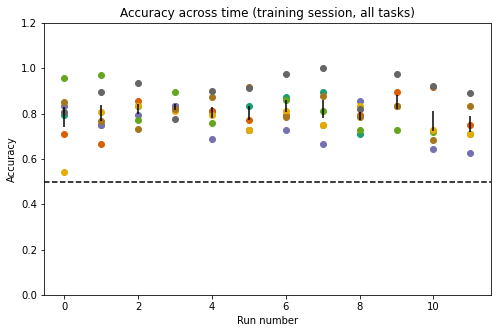

In [19]:
subcolors = cm.Dark2(np.linspace(0,1,n_subj))

plt.figure(figsize=(8,5))
for ri in range(n_runs_total):
    vals = diff_by_run[:,ri]
    
    for si in range(n_subj):
        plt.plot(ri, vals[si], 'o', color=subcolors[si,:])
    vals = vals[~np.isnan(vals)]
    m = np.mean(vals)
    s = np.std(vals)/np.sqrt(len(vals))
    plt.errorbar(ri, m, s, color='k', zorder=10)
    
plt.ylabel('Accuracy')
plt.axhline(0.5, color='k', linestyle='--')
plt.title('Accuracy across time (training session, all tasks)');
plt.xlabel('Run number');
plt.ylim([0.0, 1.2]);

# for se in np.arange(0, 37, 12):
#     plt.axvline(se-0.5, color=[0.9, 0.9, 0.9]);

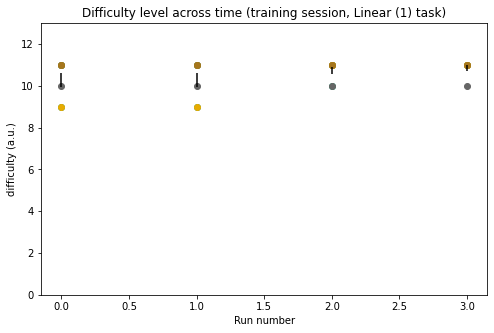

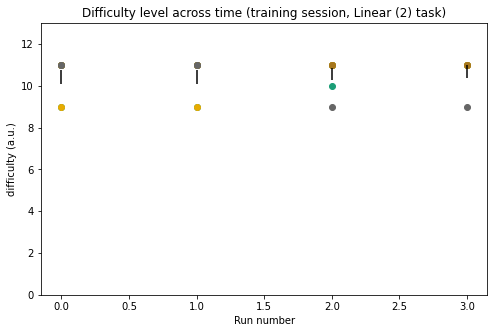

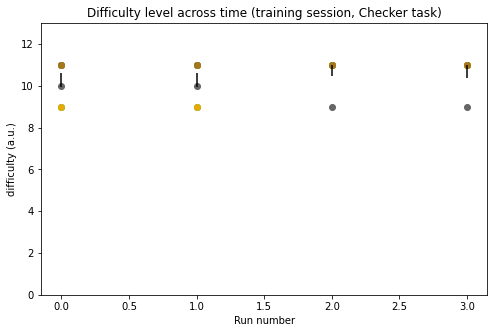

In [36]:
subcolors = cm.Dark2(np.linspace(0,1,n_subj))

for ti in range(n_tasks):
    
    plt.figure(figsize=(8,5))
    
    for ri in range(4):
        vals = diff_by_task[:,ti,ri]

        for si in range(n_subj):
            plt.plot(ri, vals[si], 'o', color=subcolors[si,:])
        vals = vals[~np.isnan(vals)]
        m = np.mean(vals)
        s = np.std(vals)/np.sqrt(len(vals))
        plt.errorbar(ri, m, s, color='k', zorder=10)

    # plt.ylabel('Accuracy')
    # plt.axhline(0.5, color='k', linestyle='--')
    plt.title('Difficulty level across time (training session, %s task)'%task_names[ti]);
    plt.xlabel('Run number');
    plt.ylabel('difficulty (a.u.)')
    plt.ylim([0,13])
    # plt.ylim([0.0, 1.2]);

# for se in np.arange(0, 37, 12):
#     plt.axvline(se-0.5, color=[0.9, 0.9, 0.9]);

#### counting training runs

In [8]:
subinits = ['S%02.f'%ss for ss in sublist]
nSubj = len(sublist)
# % names of the tasks
tasklist = ['Linear (1)','Linear (2)','Checker'];
nTasks = len(tasklist);

# % info about main categorization tasks
nRunsPerPart = 2;
nPartsPerTask = 2;  
# 2 mappings per task
nPartsTotal  = nTasks*nPartsPerTask;

for si, ss in enumerate(sublist):
    subinit = subinits[si]
    bdir = os.path.join(root, 'DataBehavior', subinit, 'Training')

    mainfiles = os.listdir(bdir)
    mainfiles = [m for m in mainfiles if 'MainTask' in m and 'TRAINING' not in m]
    datestr = mainfiles[0].split('.mat')[0][-6:]
    # for several subjects, we actually entered a different subject number here
    # than we used during scanning. grab the "training subject initial" here
    train_subinit = mainfiles[0][0:3] 
    print(datestr, train_subinit) 

    for pp in range(nPartsTotal):

        
        if si==0:
            fn = os.path.join(bdir, '%s_MainTaskMRI_feedback_sess%d_part%d_TRAINING_%s.mat'%\
                              (train_subinit, np.floor(pp/3)+1, np.mod(pp,3)+1, datestr))
        else:
            fn = os.path.join(bdir, '%s_MainTaskMRI_nofeedback_sess%d_part%d_TRAINING_%s.mat'%\
                              (train_subinit, np.floor(pp/3)+1, np.mod(pp,3)+1, datestr))

        print(fn)
        TheData = file_utils.load_mat_behav_data(fn)
        print(len(TheData))
        
        
        
        
#         if si==0:
#             fn = os.path.join(bdir, '%s_MainTaskMRI_feedback_sess1_part%d_%s.mat'%\
#                           (train_subinit, pp+1, datestr))
#         else:
#             fn = os.path.join(bdir, '%s_MainTaskMRI_nofeedback_sess%d_part%d_%s.mat'%\
#                               (train_subinit, np.floor(pp/3)+1, np.mod(pp,3)+1, datestr))

#         print(fn)
#         TheData = file_utils.load_mat_behav_data(fn)
#         print(len(TheData))

210406 S01
/usr/local/serenceslab/maggie/shapeDim/DataBehavior/S01/Training/S01_MainTaskMRI_feedback_sess1_part1_TRAINING_210406.mat
1
/usr/local/serenceslab/maggie/shapeDim/DataBehavior/S01/Training/S01_MainTaskMRI_feedback_sess1_part2_TRAINING_210406.mat
1
/usr/local/serenceslab/maggie/shapeDim/DataBehavior/S01/Training/S01_MainTaskMRI_feedback_sess1_part3_TRAINING_210406.mat
1
/usr/local/serenceslab/maggie/shapeDim/DataBehavior/S01/Training/S01_MainTaskMRI_feedback_sess2_part1_TRAINING_210406.mat
1
/usr/local/serenceslab/maggie/shapeDim/DataBehavior/S01/Training/S01_MainTaskMRI_feedback_sess2_part2_TRAINING_210406.mat
1
/usr/local/serenceslab/maggie/shapeDim/DataBehavior/S01/Training/S01_MainTaskMRI_feedback_sess2_part3_TRAINING_210406.mat
1
210625 S05
/usr/local/serenceslab/maggie/shapeDim/DataBehavior/S02/Training/S05_MainTaskMRI_nofeedback_sess1_part1_TRAINING_210625.mat
1
/usr/local/serenceslab/maggie/shapeDim/DataBehavior/S02/Training/S05_MainTaskMRI_nofeedback_sess1_part2_TRAI